In [1]:
using VMLS
using LinearAlgebra

## Chapter 13
# Least squares data fitting
### 13.1 Least squares data fitting
**Straight-line fit.** A straight-line fit to time series data gives an estimate of a
trend line. In Figure [13.3](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.13.3) of VMLS we apply this to a time series of petroleum consumption. The figure is reproduced here as Figure 13.1.

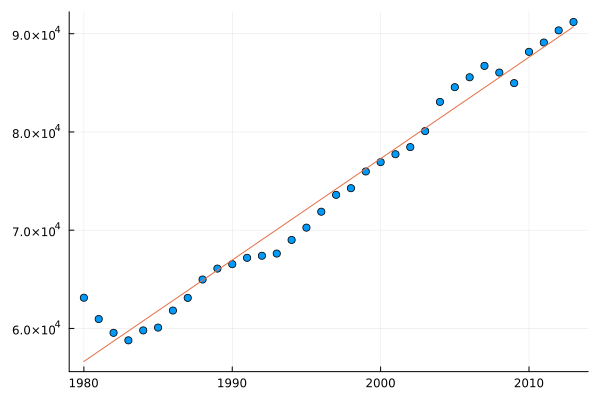

In [2]:
# Petroleum consumption in thousand barrels/day
consumption = petroleum_consumption_data()
n = length(consumption);
A = [ ones(n) 1:n ];
x = A \ consumption;
using Plots
scatter(1980:2013, consumption, legend=false)
plot!(1980:2013, A*x)

**Figure 13.1** World petroleum consumption between $1980$ and $2013$ (dots)
and least squares straight-line fit (data from www.eia.gov).

**Estimation of trend and seasonal component.** The next example is the least squares fit of a trend plus a periodic component to a time series. In VMLS this was illustrated with a time series of vehicle miles traveled in the US, per month, for $15$ years ($2000–2014$). The following Julia code replicates Figure [13.5](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.13.5) in VMLS. It imports the data via the function `vehicle_miles_data`, which creates a $15 × 12$ matrix `vmt`, with the monthly values for each of the $15$ years.

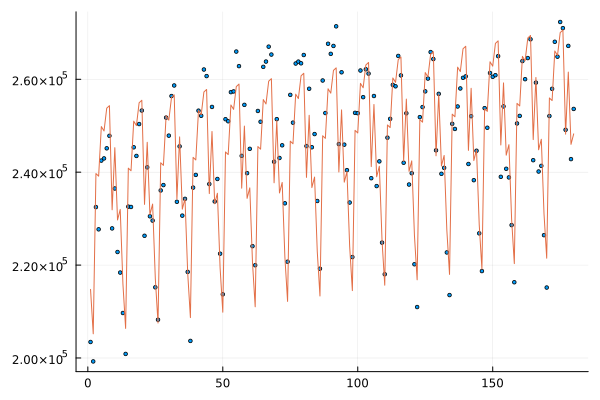

In [3]:
 vmt = vehicle_miles_data(); # creates 15x12 matrix vmt
 m = 15*12;
 A = [ 0:(m-1) vcat([eye(12) for i=1:15]...) ];
 b = reshape(vmt', m, 1);
 x = A \ b;
 using Plots
 scatter(1:m, b, markersize = 2, legend =false);
 plot!(1:m, A*x)

<a id='page_100'></a>
**Figure 13.2** The dots show vehicle miles traveled in the US, per month, in the period January $2000$–December $2014$. The line shows the least squares fit of a linear trend and a seasonal component with a $12$-month period.

The matrix $A$ in this example has size $m×n$ where $m = 15 · 12 = 180$ and $n = 13$. The first column has entries $0, 1, 2, . . . , 179$. The remaining columns are formed by vertical stacking of $15$ identity matrices of size $12 × 12$. The Julia expression `vcat([eye(12) for i=1:15]...)` creates an array of 15 identity matrices, and then stacks them vertically. The plot produced by the code is shown in Figure 13.2. 

**Polynomial fit.** We now discuss the polynomial fitting problem on page [255](        https://web.stanford.edu/~boyd/vmls/vmls.pdf#section*.300) in VMLS and the results shown in Figure [13.6](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.13.6). We first generate a training set of $100$ points and plot them (Figure 13.3).

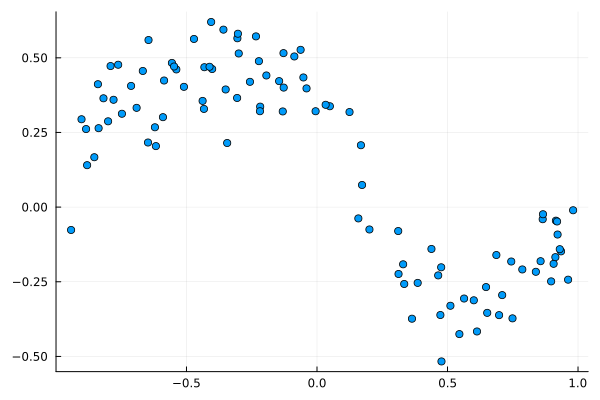

In [4]:
# Generate training data in the interval [-1, 1].
m = 100;
t = -1 .+ 2*rand(m,1);
y = t.^3 - t + 0.4 ./ (1 .+ 25*t.^2) + 0.10*randn(m,1);
using Plots
scatter(t,y,legend=false)

**Figure 13.3** Training set used in the polynomial fitting example.

Next we define a function that fits the polynomial coefficients using least squares.
We apply the function to fit polynomials of degree $2, 6, 10, 15$ to our training set.

In [5]:
polyfit(t, y, p) = vandermonde(t, p) \ y
theta2 = polyfit(t,y,3)

3×1 Matrix{Float64}:
  0.2207109708784165
 -0.3934694481192321
 -0.21830848952068338

In [6]:
theta6 = polyfit(t,y,7);
theta10 = polyfit(t,y,11);
theta15 = polyfit(t,y,16);

Finally, we plot the four polynomials. To simplify this, we first write a function that evaluates a polynomial at all points specified in a vector `x`. The plots are in Figure 13.4.

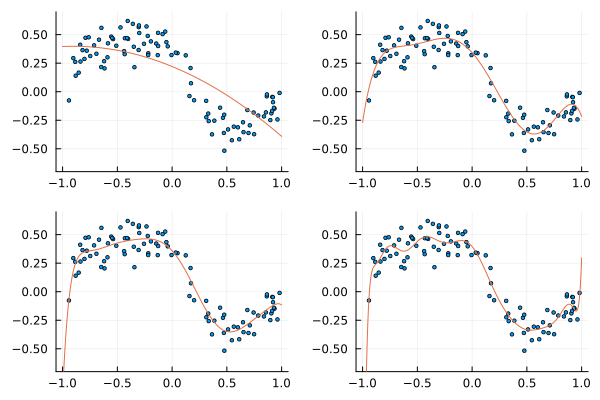

In [7]:
polyeval(theta, x) = vandermonde(x,length(theta))*theta;
t_plot = linspace(-1,1,1000);
using Plots
p = plot(layout=4, legend=false, ylim=(-0.7, 0.7))
scatter!(t, y, subplot=1, markersize = 2)
plot!(t_plot, polyeval(theta2,t_plot), subplot=1)
scatter!(t, y, subplot=2, markersize = 2)
plot!(t_plot, polyeval(theta6,t_plot), subplot=2)
scatter!(t, y, subplot=3,markersize = 2)
plot!(t_plot, polyeval(theta10,t_plot), subplot=3)
scatter!(t, y, subplot=4, markersize = 2)
plot!(t_plot, polyeval(theta15,t_plot), subplot=4)

**Figure 13.4** Least squares polynomial fits of degree $1, 6, 10$, and $15$ to $100$
points

**Piecewise-linear fit.** In the following code least squares is used to fit a piecewise-linear function to $100$ points. It produces Figure 13.5, which is similar to Figure [13.8](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.13.8) in VMLS.

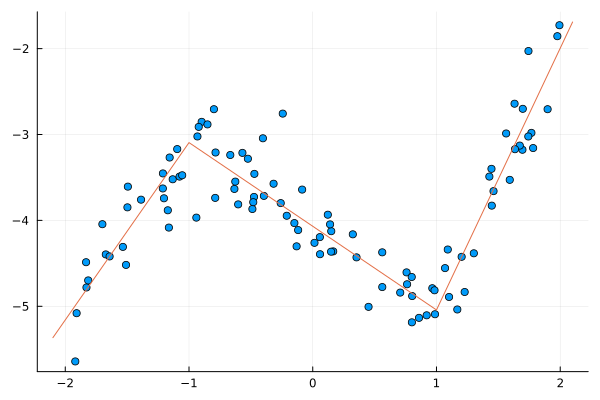

In [8]:
# generate random data
m = 100;
x = -2 .+ 4*rand(m,1);
y = 1 .+ 2*(x.-1) - 3*max.(x.+1,0) + 4*max.(x.-1,0) + 0.3*randn(m,1);
# least squares fitting
theta = [ ones(m) x max.(x.+1,0) max.(x.-1,0) ] \ y;
# plot result
using Plots
t = [-2.1, -1, 1, 2.1];
yhat = theta[1] .+ theta[2]*t + theta[3]*max.(t.+1,0) +
theta[4]*max.(t.-1,0);
scatter(x, y, legend=false)
plot!(t, yhat)

**Figure 13.5** Piecewise-linear fit to $100$ points.

**House price regression.** We calculate the simple regression model for predicting
house sales price from area and number of bedrooms, using the data of $774$ house
sales in Sacramento.

In [9]:
D = house_sales_data(); # creates 3 vectors: area, beds, price
area = D["area"];
beds = D["beds"];
price = D["price"];
m = length(price);
A = [ ones(m) area beds ];
x = A \ price

3-element Vector{Float64}:
  54.40167360394433
 148.72507260029033
 -18.853357877778716

In [10]:
rms_error = rms(price - A*x)

74.84571649590144

In [11]:
std_prices = stdev(price)

112.78216159756509

**Auto-regressive time series model.** In the following Julia code we fit an auto-
regressive model to the temperature time series discussed on page [259](https://web.stanford.edu/~boyd/vmls/vmls.pdf#section*.304) of VMLS. In Figure 13.6 we compare the first five days of the model predictions with the data. 

In [12]:
t = temperature_data(); # import time series of temperatures t
N = length(t)

744

In [13]:
stdev(t) # Standard deviation

3.050559285629329

In [14]:
rms(t[2:end] - t[1:end-1]) # RMS error for simple predictor zhat_{t+1} = z_t

1.1602431638206117

In [15]:
rms(t[25:end] - t[1:end-24]) # RMS error for simple predictor zhat_{t+1} = z_{t-23}

1.7338941400468812

In [16]:
M = 8 # Least squares fit of AR predictor with memory 8
y = t[M+1:end];
A = hcat( [ t[i:i+N-M-1] for i = M:-1:1]...);
theta = A \ y;
ypred = A*theta;
# RMS error of LS AR fit
rms(ypred - y)

1.0129632612687514

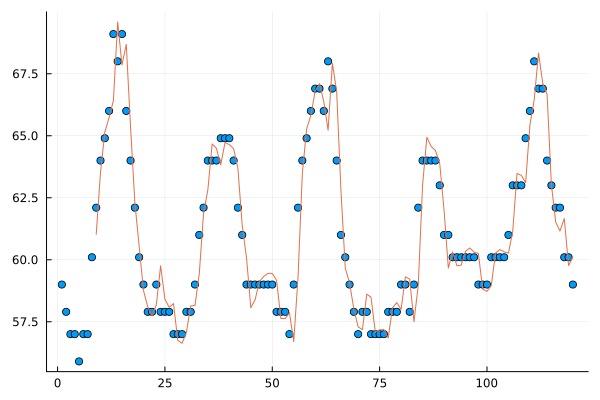

In [17]:
# Plot first five days
using Plots
Nplot = 24*5
scatter(1:Nplot, t[1:Nplot], legend =false)
plot!(M+1:Nplot, ypred[1:Nplot-M])

**Figure 13.6** Hourly temperature at Los Angeles International Airport between 12:53AM on May 1, 2016, and 11:53PM on May 5, 2016, shown as circles. The solid line is the prediction of an auto-regressive model with eight coefficients.

### 13.2 Validation
**Polynomial approximation.** We return to the polynomial fitting example of page [100](#page_100). We continue with the data vectors `t` and `y` in the code on page [100](#page_100) as the training set, and generate a test set of $100$ randomly chosen points generated by the same method as used for the training set. We then fit polynomials of degree $0,. . . , 20$ (i.e., with $p = 1, . . . , 21$ coefficients) and compute the RMS errors on the training set and the test set. This produces a figure similar to Figure [13.11](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.13.11) in VMLS, shown here as Figure 13.7. 

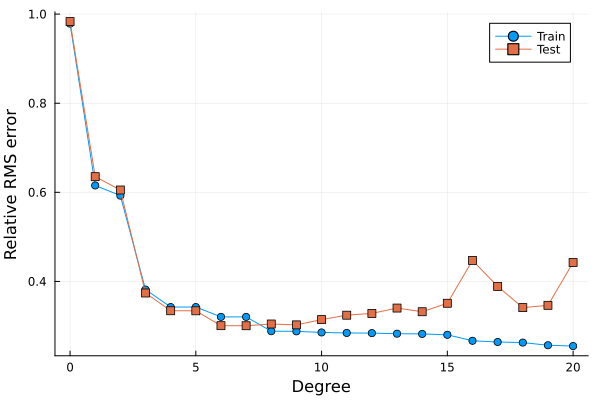

In [18]:
# Generate the test set.
m = 100;
t = -1 .+ 2*rand(m,1);

y = t.^3 - t + 0.4 ./ (1 .+ 25*t.^2) + 0.10*randn(m,1);
N = length(t)
t_test = -1 .+ 2*rand(m,1);

y_test = t_test.^3 - t_test + 0.4 ./ (1 .+ 25*t_test.^2) + 0.10*randn(m,1);
error_train = zeros(21);
error_test = zeros(21);

for p = 1:21
    A = vandermonde(t,p)
    theta = A \ y
    error_train[p] = norm(A*theta - y) / norm(y)
    error_test[p] = norm( vandermonde(t_test, p) * theta - y_test) / norm(y_test);
end
using Plots
plot(0:20, error_train, label = "Train", marker = :circle)
plot!(0:20, error_test, label = "Test", marker = :square)
plot!(xlabel="Degree", ylabel = "Relative RMS error")

**Figure 13.7** RMS error versus polynomial degree for the fitting example in
figure 13.4.

**House price regression model.** On page 13.1 we used a data set of $774$ house sales data to fit a simple regression model
$$
ŷ = v + β_1x_1 + β_2x_2,
$$ where $ŷ$ is the predicted sales price, $x_1$ is the area, and $x_2$ is the number of bedrooms. Here we apply cross-validation to assess the generalization ability of the simple model. We use five folds, four of size $155$ ($N$fold in the code below) and one of size $154$. To choose the five folds, we create a random permutation of the indices $1, . . . , 774$. (We do this by calling the randperm function in the `Random` package.) We choose the data points indexed by the first $155$ elements in the permuted list as fold 1, the next $155$ as fold $2$, et cetera. The output of the following code outputs is similar to Table [13.1](https://web.stanford.edu/~boyd/vmls/vmls.pdf#table.13.1) in VMLS (with different numbers because of the random choice of folds). 

<a id='page_106'></a>

In [19]:
D = house_sales_data();
price = D["price"]; area = D["area"]; beds = D["beds"];
N = length(price);
X = [ ones(N) area beds ];
nfold = div(N,5); # size of first four folds
import Random
I = Random.randperm(N); # random permutation of numbers 1...N
coeff = zeros(5,3); errors = zeros(5,2);
rms_train = zeros(0)
rms_test = zeros(0)
for k = 1:5
    if k == 1
        Itrain = I[nfold+1:end];
        Itest = I[1:nfold];
        elseif k == 5
        Itrain = I[1:4*nfold];
        Itest = I[4*nfold+1:end];
    else
        Itrain = I[ [1:(k-1)*nfold ; k*nfold+1 : N]]
        Itest = I[ [(k-1)*nfold+1 ; k*nfold ]];
        end;
    Ntrain = length(Itrain)
    Ntest = length(Itest)
    theta = X[Itrain,:] \ price[Itrain];
    coeff[k,:] = theta;
    append!(rms_train, rms(X[Itrain,:] * theta - price[Itrain]))
    append!(rms_test, rms(X[Itest,:] * theta - price[Itest]))
    end;
coeff # 3 coefficients for the five folds

5×3 Matrix{Float64}:
 60.6577  146.442  -19.7079
 59.7256  147.507  -20.2803
 36.9132  147.176  -12.7016
 51.3312  153.352  -19.9675
 63.0121  149.257  -21.5259

In [20]:
[rms_train rms_test] # RMS errors for five folds

5×2 Matrix{Float64}:
 75.5926  71.9019
 75.3529  51.6668
 71.9098  31.5321
 75.3714  91.5639
 75.6819  71.6459

**Validating time series predictions.** In the next example, we return to the $AR$
model of hourly temperatures at $LAX$. We divide the time series in a training set
of $24$ days and a test set of $7$ days. We fit the $AR$ model to the training set and
calculate the $RMS$ prediction errors on the training and test sets. Figure 13.8
shows the model predictions and the the data for the first five days of the test set.

In [21]:
t = temperature_data();
N = length(t);
# use first 24 days as training set
Ntrain = 24 * 24; t_train = t[1:Ntrain];
# use the rest as test set
Ntest = N-Ntrain; t_test = t[Ntrain+1:end];
# Least squares fit of AR predictor with memory 8
m = Ntrain - M;
y = t_train[M+1:M+m];
A = hcat( [t_train[i:i+m-1] for i=M:-1:1]...);
coeff = A \ y;
rms_train = rms(A*coeff-y)

1.025357725986232

In [22]:
ytest = t_test[M+1:end];
mtest = length(ytest);
ypred = hcat( [t_test[i:i+mtest-1] for i=M:-1:1]...) * coeff;
rms_test = rms(ypred - ytest)

0.9755113632201057

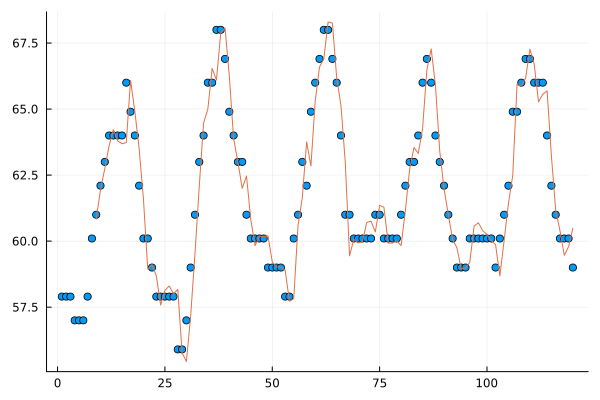

In [23]:
using Plots
Nplot = 24*5
scatter(1:Nplot, t_test[1:Nplot], legend=false)
plot!(M+1:Nplot, ypred[1:Nplot-M])

**Figure 13.8** Hourly temperature at Los Angeles International Airport be-
tween $12:53AM$ on $May 25$, $2016$, and $11:53PM$ on $May 29$, $2016$, shown
as circles. The solid line is the prediction of an auto-regressive model with
eight coefficients, developed using training data from $May 1$ to $May 24$.

### 13.3 Feature engineering
Next we compute the more complicated house price regression model of §[13.3.5](https://web.stanford.edu/~boyd/vmls/vmls.pdf#subsection.13.3.5) of VMLS. The data are imported via the function house_sales_data, which returns a dictionary containing the following five vectors of length `774`: 
* price: price in thousand dollars,
* area: house area in $1000$ square feet,
* beds: number of bedrooms,
* condo: `1` if a condo, `0` otherwise,
* location: a number from `1–4`, for the four sets of ZIP codes in Table [13.4](https://web.stanford.edu/~boyd/vmls/vmls.pdf#table.13.4) of VMLS.

The code computes the model and makes a scatter plot of actual and predicted
prices (Figure 13.9). Note that the last three columns of the matrix `X` contain
$Boolean$ variables (`true` or `false`). We rely on the fact that Julia treats this as
integers `1` and `0`. 

In [24]:
D = house_sales_data();
price = D["price"];
area = D["area"];
beds = D["beds"];
condo = D["condo"];
location = D["location"];
N = length(price);
X = hcat(ones(N), area, max.(area.-1.5, 0), beds, condo, location .== 2, location .== 3, location .== 4 );
theta = X \ price

8-element Vector{Float64}:
  115.6168236702552
  175.41314063995878
  -42.747767967826526
  -17.87835523524323
  -19.044725650546408
 -100.91050308608285
 -108.79112222093224
  -24.765247347061937

In [25]:
rms(X*theta - price) # RMS prediction error

68.34428699036887

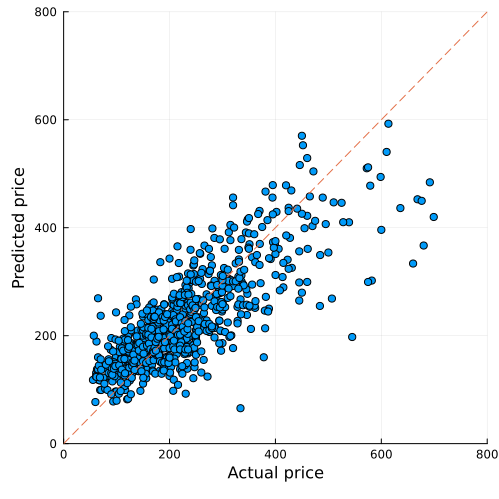

In [26]:
using Plots
scatter(price, X*theta, lims = (0,800))
plot!([0, 800], [0, 800], linestyle = :dash, legend = false)
plot!(xlims = (0,800), ylims = (0,800), size = (500,500))
plot!(xlabel = "Actual price", ylabel = "Predicted price")

**Figure 13.9** Scatter plot of actual and predicted prices for a model with eight
parameters.
    
We finish by a cross-validation of this method. We follow the same approach as for
the simple regression model on page [106](#page_106), using five randomly chosen folds. The
code shows the eight coefficients, and the RMS training and test errors for each
fold.

In [27]:
N = length(price);
nfold = div(N,5);
import Random;
I = Random.randperm(N);
models = zeros(8,5); # store 8 coefficients for the 5 models
errors = zeros(2,5); # prediction errors
for k = 1:5
    if k == 1
        Itrain = I[nfold+1:end];
        Itest = I[1:nfold];
        elseif k == 5
        Itrain = I[1:4*nfold];
        Itest = I[4*nfold+1:end];
    else
        Itrain = I[ [1:(k-1)*nfold ; k*nfold+1 : N]]
        Itest = I[ [(k-1)*nfold+1 ; k*nfold ]];
        end;
    Ntrain = length(Itrain)
    Ntest = length(Itest)
    theta = X[Itrain,:] \ price[Itrain];
    errors[1,k] = rms(X[Itrain,:] * theta - price[Itrain]);
    errors[2,k] = rms(X[Itest,:] * theta - price[Itest]);
    models[:,k] = theta;
end;
# display the eight coefficients for each of the 5 folds 
models

8×5 Matrix{Float64}:
 106.059    103.032    135.307    135.696    100.699
 179.838    180.971    164.996    166.417    183.108
 -45.4396   -52.802    -29.3709   -35.8403   -48.3866
 -20.372    -15.5899   -19.4975   -17.3351   -16.1125
 -21.5055   -13.0893   -28.3005   -22.4126    -8.47636
 -88.6925  -100.433   -103.552   -109.833   -104.164
 -95.9025  -109.941   -108.549   -120.142   -111.365
 -10.6153   -29.4009   -30.1141   -35.2876   -18.9524

In [28]:
#display training errors (1st row) and test errors (2nd) row
errors

2×5 Matrix{Float64}:
 68.1367  68.9055  67.5583  66.7715  69.9065
 69.4393  89.3427  77.8759  10.8923  62.6933